In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 224
CHANNELS=4
EPOCHS=50

In [ ]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "train",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3000 files belonging to 3 classes.


In [ ]:
class_names = dataset.class_names
class_names

['airplanes', 'cars', 'ship']

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 224, 224, 3)
[1 0 0 1 0 0 1 2 1 0 2 1 0 1 0 2 0 0 0 2 0 2 0 0 2 1 0 2 0 2 1 2]


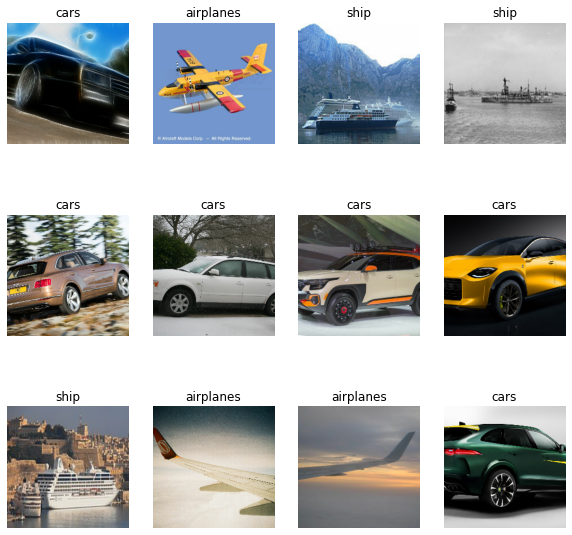

In [ ]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [ ]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
model = tf.keras.applications.DenseNet201(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
)

In [ ]:
model.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=['accuracy'])

In [ ]:
model.fit(train_ds,epochs=1,batch_size=32,verbose=1,validation_data=val_ds)

75/75 [==============================] - 5479s 73s/step - loss: 0.6072 - accuracy: 0.8650 - val_loss: 50.9721 - val_accuracy: 0.3090


In [ ]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(img.numpy())
    img_array = tf.expand_dims(img_array,0)
    predictions = model.predict(img_array)
    predicted_class=dataset.class_names[np.argmax(predictions)]
    confidence = round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

<ipython-input-52-c34147507bfe>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax= plt.subplot(3,3,i+1)


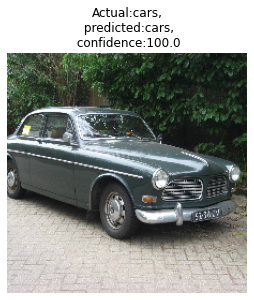

In [ ]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(2):
    predicted_class,confidence = predict(model,images[i])
    plt.title(f"Actual:{dataset.class_names[labels[i]]},\n predicted:{predicted_class},\n confidence:{confidence}")
    ax= plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.axis('off')